# CNN - AE model validation

1. Import data. Namely, CNN - AE encoded vectors, raw data (to be transformed in count scaled data and tfidf-matix), LSTM encoded vectors;

2. t-SNE for visualization with predetermined classes. Classes can be: (a) first diagnosis, (b) disease vs OTH, (c) comorbidities classes;

3. Hierarchical clustering with `n_clusters = c_classes`. External cluster validation (entropy and purity) and cluster similarities [mean of (1 - euclidean distances)];

4. For each disease class perform hierarchical clustering and select the number of clusters that maximize the internal validation measure (e.g. silhouette index). Then count the most frequent terms. Lastly, perform the odds ration chi-squared test for the most frequent term of each cluster. 

Contingency table:

|Clusters|MFT_0|MFT_1|
|-------|----|----|
|Clust_1|n_01|n_11|
|Clust_2|n_02|n_12|
|...|...|...|
|Clust_n|n_0n|n_1n|

MFT = Most Frequent Term

MFT_0 = number of subjects in Cluster_i without term MFT

MFT_1 = number of subjects in Cluster_i with term MFT

In [2]:
import os
import csv

import random
import numpy as np

from sklearn.manifold.t_sne import TSNE
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, scale
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA, TruncatedSVD
from collections import OrderedDict
from scipy import stats
import scipy
import umap 

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

### Read data

In [55]:
##Set folder names
# f = open('../outdir.txt', 'r')
# outdir = f.read().rstrip('\n')
# f = open('../experiment_folder.txt', 'r')
# experiment_folder = f.read().rstrip('\n')
outdir = os.path.expanduser("~/data1/stratification_ILRM/data/mixed/cohorts/2019-1-8-12-25-16")
experiment_folder = os.path.expanduser("/home/riccardo/data1/projects/ehr-stratification/data/experiments/mixed-2019-02-26-10-42-59")

##Read encoded vectors file and ordered medical record numbers
with open(experiment_folder + '/encoded_vect.csv') as f:
    rd = csv.reader(f)
    encoded_vect = []
    for r in rd:
        encoded_vect.append(list(map(float, r)))
with open(experiment_folder + '/mrns.csv') as f:
    rd = csv.reader(f)
    mrns = []
    for r in rd:
        mrns.append(r[0])
        
# ##Read LSTM encoded vectors file and ordered medical record numbers
# with open(experiment_folder + '/LSTMencoded_vect.csv') as f:
#     rd = csv.reader(f)
#     lstm_encoded_vect = []
#     for r in rd:
#         lstm_encoded_vect.append(list(map(float, r)))       
# with open(experiment_folder + '/LSTMmrns.csv') as f:
#     rd = csv.reader(f)
#     lstm_mrns = []
#     for r in rd:
#         lstm_mrns.append(r[0])

##Read vocabulary
with open(outdir + '/cohort-new_vocab.csv') as f:
    rd = csv.reader(f)
    next(rd)
    new_vocab = {}
    for r in rd:
        new_vocab[r[1]] = r[0]
len_vocab = len(new_vocab)

##Read raw data
with open(outdir + '/cohort-new_ehr.csv') as f:
    rd = csv.reader(f)
    raw_ehr = {}
    for r in rd:
        raw_ehr.setdefault(r[0], list()).extend(list(map(int, r[1::])))
mrn_list = [m for m in raw_ehr.keys()]
##raw data scaled counts
scaler = StandardScaler()
raw_data_counts = np.zeros((len(raw_ehr), len_vocab))
idx = 0
for _, token_list in raw_ehr.items():
    for t in token_list:
        if t != 0: ##we start the vocabulary from 1
            raw_data_counts[idx, t-1] += 1
    idx += 1
raw_data_scaled = scaler.fit_transform(raw_data_counts)

##get list of diagnosed diseases associated with mrns
with open(outdir + '/cohort-mrn_diseases.csv') as f:
    rd = csv.reader(f)
    mrn_disease = {}
    for r in rd:
        mrn_disease[r[0]] = r[1::]
##Possible disease classes:
##1)consider comorbidities as new class
comorbid_disease = {}
for m in mrn_disease:
    if len(mrn_disease[m]) == 1:
        comorbid_disease[m] = mrn_disease[m][0]
    else:
        comorbid_disease[m] = ('-'.join(mrn_disease[m][0::]))
##2)consider two classes: disease vs OTH
oth_disease = {}
for m in mrn_disease:
    if mrn_disease[m][0] == 'OTH':
        oth_disease[m] = mrn_disease[m][0]
    else:
        oth_disease[m] = 'disorder'
##3) first diagnosis
first_disease = {}
for m in mrn_disease:
    first_disease[m] = mrn_disease[m][0]

### Functions

>`svd_tfidf()`: returns the SVD matrix of the TFIDF matrix of the raw ehr data;

>`hclust_ehr()`: performs the hierarchical clustering on input data maximizing the Silhouette Index, it returns the number of clusters and the labels;

>`FreqDict()`: returns the frequencies of the medical terms in ehrs;

>`freq_term()`: returns the cluster and the first n most frequent terms in the cluster, the relative frequency w.r.t the whole dataset is given;

>`single_plot()`: returns a plot of all the clusters;

>`nonoveralp_plot()`: returns N different plots with N the number of clusters;

> `ext_clust()`: external validation of clustering. Returns Entropy and Purity scores;

> `disease_sim()`: compute disease similarity of the patient representations.

In [28]:
##Hierarchical clustering function
def hclust_ehr(data, min_cl, max_cl, metric):
    best_silh = 0.0
    list_silh = []
    for n in range(min_cl,max_cl,1):
        hclust = AgglomerativeClustering(n_clusters=n, 
                                         linkage='ward', 
                                         affinity=metric)
        tmp_label = hclust.fit_predict(data).tolist()
        tmp_silh = silhouette_score(data, tmp_label)
        print(n, tmp_silh)
        list_silh.append(float(tmp_silh))
        if tmp_silh > best_silh:
            best_silh = tmp_silh
            n_clust = n
            label = tmp_label
    try:
        print("Number of clusters found:{0}, Silhouette score:{1:.3f}\n".format(n_clust, best_silh))
    except UnboundLocalError:
        hclust = AgglomerativeClustering(n_clusters=min_cl,
                                         linkage='ward',
                                         affinity=metric)
        n_clust = min_cl
        label = hclust.fit_predict(data).tolist()
        print("Number of clusters found:{0}, Silhouette score:{1:.3f}\n".format(n_clust, best_silh))
    return n_clust, label, list_silh

def svd_tfidf(data, len_vocab):   
    count_mat = np.zeros((len(data), len_vocab))
    idx = 0
    for _, token_list in data.items():
        for t in token_list:
            if t != 0: ##we start the vocabulary from 1
                count_mat[idx, t-1] += 1
        idx += 1
    tfidf = TfidfTransformer()
    tfidf_mat = tfidf.fit_transform(count_mat)
    svd = TruncatedSVD(n_components=100)
    svd_mat = svd.fit_transform(tfidf_mat)
    return svd_mat

def FreqDict(tokens):
    freq_dict = {}
    for seq in tokens:
        for s in seq:
            if s not in freq_dict:
                freq_dict[s] = 1
            else:
                freq_dict[s] += 1
    return freq_dict

def freq_term(data, mrn_list, n_clusters, pred_class, n, term_list):
    encoded_groups = OrderedDict()
    encoded_seq = OrderedDict()
    for i in range(n_clusters):
        encoded_groups[i] = []
        encoded_seq[i] = []
        for j in range(len(pred_class)):
            if pred_class[j] == i:
                encoded_groups[i] += [mrn_list[j]]
                encoded_seq[i].append([rd for rd in data[j] if rd!=0 and (str.split(new_vocab[str(rd)], "::")[0] in term_list)])
    list_terms = []
    for cl in range(n_clusters):
        print("Cluster {0} numerosity: {1}".format(cl, len(encoded_groups[cl])))
        encoded_count = FreqDict(encoded_seq[cl])
        clust_mostfreq = []
        for l in range(n):
            try:
                MFMT = max(encoded_count, key=(lambda key: encoded_count[key]))
                num_MFMT = 0
                count_pat = 0
                for ec in encoded_seq[cl]:
                    if MFMT in ec:
                        count_pat += 1
                for el in data:
                    for t in el:
                        if t == MFMT:
                            num_MFMT += 1
                print("Cluster {0} -- Relative numerosity of first most frequent term:{1} = {2:.2f} (count term {3} -- N patients {4})".format(cl,
                                                                                                new_vocab[str(MFMT)], 
                                                                                                encoded_count[MFMT]/num_MFMT, 
                                                                                                encoded_count[MFMT],
                                                                                                count_pat))
                encoded_count.pop(MFMT)
                clust_mostfreq.append(MFMT)
            except ValueError:
                pass
        print("\n")
        list_terms.append(clust_mostfreq)
    return list_terms

def single_plot(data, mrn_disease, colors):
    plt.figure(figsize=(20,10))
    for cl in set(mrn_disease):
        x = [d[0] for j, d in enumerate(data) if mrn_disease[j]==cl]
        y = [d[1] for j, d in enumerate(data) if mrn_disease[j]==cl]
        cols = [c for j, c in enumerate(colors) if mrn_disease[j]==cl]
        plt.xticks([])
        plt.yticks([])
        plt.scatter(x, y, c=cols, label=cl)
    plt.legend()
    
def nonoverlap_plot(data, mrn_disease, colors):
    fig, ax = plt.subplots(len(set(mrn_disease)), 1, figsize=(20, 10*len(set(mrn_disease))))
    for idx, cl in enumerate(set(mrn_disease)):
        x = [d[0] for j, d in enumerate(data) if mrn_disease[j]==cl]
        y = [d[1] for j, d in enumerate(data) if mrn_disease[j]==cl]
        cols = [c for j, c in enumerate(colors) if mrn_disease[j]==cl]
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
        ax[idx].scatter(x, y, c=cols, label=cl)
        ax[idx].legend()

In [46]:
##Hierarchical clustering: external validation. Number of clusters = Number of chosen classes
# def ext_clust(disease_vect, clust_vect):
#     dis_dict = {}
#     for idx, d in enumerate(set(disease_vect)):
#         dis_dict[d] = idx
#     labels = [dis_dict[d] for d in disease_vect]
#     count_clust = [0] * len(set(clust_vect))
#     for c in clust_vect:
#         count_clust[c] += 1
#     class_clust = []
#     for _ in range(len(set(labels))):
#         class_clust.append([0 for _ in range(len(set(clust_vect)))])
#     for idx, l in enumerate(labels):
#         c = clust_vect[idx]
#         class_clust[l][c] += 1
#     e = 0
#     pur = 0
#     for j in range(0, max(clust_vect)+1):
#         ej = 0
#         p = []
#         for i in range(0, max(labels)+1):
#             pij = class_clust[i][j]/count_clust[j]
#             p.append(pij)
#             if pij != 0:
#                 ej += -(pij * np.log2(pij)) 
#         print("Cluster {0} -- Entropy: {1:.3f}, Purity: {2:.3f}".format(j, ej, max(p)))
#         e += count_clust[j]/len(labels) * ej
#         pur += count_clust[j]/len(labels) * max(p)
#     print("Average Entropy for clustering: {0:.3f}".format(e))
#     print("Average Purity for clustering: {0:.3f}".format(pur))

def outer_clustering_analysis(data, gt_clu, affinity_clu='euclidean'):
    label_clu = sorted(set(gt_clu))

    # format clustering ground truth
    didx = {d: i for i, d in enumerate(label_clu)}
    idxd = {i:d for d, i in didx.items()}
    gt = [didx[d] for d in gt_clu]

    # validate cluster number
    if len(label_clu) == 1:
        n_clu = 3
    else:
        n_clu = len(label_clu)

    # run clustering
    hclust = AgglomerativeClustering(n_clusters=n_clu,
                                     linkage='complete',
                                     affinity=affinity_clu)
    clusters = hclust.fit_predict(data).tolist()

    # count cluster occurrences
    cnt_clu = [0] * n_clu
    for c in clusters:
        cnt_clu[c] += 1
    class_clu = [[0] * n_clu for _ in range(len(label_clu))]
    for i, gi in enumerate(gt):
        class_clu[gi][clusters[i]] += 1

    # compute entropy and purity
    entropy = 0
    purity = 0
    for j in range(0, max(clusters) + 1):
        en = 0
        pu = []
        for i in range(0, max(gt) + 1):
            pij = class_clu[i][j] / cnt_clu[j]
            pu.append(pij)
            if pij != 0:
                en += -(pij * np.log2(pij))
        max_pu = max(pu)
        ds_max = []
        for idx, p in enumerate(pu):
            if p == max_pu:
                ds_max.append(idxd[idx])
        print(
            'Cluster: {0} -- '
            'Entropy: {1:.3f}, '
            'Purity: {2:.3f}'.format(j, en, max_pu))
        for d in ds_max:
            print("max(P) in cluster disease {0}".format(d))
        cweight = cnt_clu[j] / len(gt)
        entropy += cweight * en
        purity += cweight * max_pu

    print('Average Entropy: {0:.2f}'.format(entropy))
    print('Average Purity: {0:.2f}'.format(purity))
    
    return clusters

In [30]:
def disease_sim(model_mat, disease_vect, model):
    for d in set(disease_vect):
        tmp_mat = []
        for idx, lab in enumerate(disease_vect):
            if lab == d:
                tmp_mat.append(model_mat[idx])
        #pair_sim = 1 / (1 + metrics.pairwise.euclidean_distances(tmp_mat))
        pair_sim = metrics.pairwise.cosine_similarity(tmp_mat)
        mu = np.mean(pair_sim)
        sd = np.std(pair_sim)
        string = "Model {0} -- Disease {1}:: similarity ({2}, {3})".format(model, d, mu, sd)
        print(string)
#     f.open(os.path.join(experiment_folder, "similarity_" + model + ".txt"), "w")
#     f.writelines([r for r in result])
#     f.close()    

In [31]:
##Odds ratio chi-2 test for most frequent terms in the subgroups
def chi_test(raw_ehr, vocab, new_classes, term, mrn):
    count_mat = np.zeros((2, len(set(new_classes))))
    for c in set(new_classes):
        for idx, m in enumerate(mrn):
            if new_classes[idx] == c:
                if term in raw_ehr[idx]:
                    count_mat[1][c] += 1
                else:
                    count_mat[0][c] += 1
    print("Count matrix:\n {0}".format(count_mat))
    chi2_stat, p_val, dof, ex = stats.chi2_contingency(count_mat)
    string = "Chi-squared test statistics: chi2_stat = {0} -- p_val = {1} -- dof = {2}".format(
                                                                  chi2_stat,
                                                                  p_val,
                                                                  dof)#row = classes, columns = vocab
    print(string)
#     f.open(os.path.join(experiment_folder), "chi2_" + model + ".txt", "w")
#     f.write(string)
#     f.close()

In [32]:
def int_clust(classes_vect, data, mrns, raw_data, vocab, tsne_data):
    new_tsne = []
    new_classes = []
    for n in set(classes_vect):
        tmp_data = []
        tmp_mrn = []
        tmp_raw = []
        for idx, c in enumerate(classes_vect):
            if c == n:
                new_tsne.append(tsne_data[idx])
                tmp_data.append(data[idx])
                tmp_mrn.append(mrns[idx])
                tmp_raw.append(raw_data[mrns[idx]])
        print("Inspecting disease: {0}\n".format(n))
        n_clust, label, _ = hclust_ehr(tmp_data, 2, 10, 'cosine')
        new_classes.extend([n + ': subclust ' + str(l) for l in label])
        list_terms = freq_term(tmp_raw, tmp_mrn, n_clust, label, 8, ['icd9', 'medication'])
        for l in range(len(set(label))):
            for lt in len(list_terms[l]):
                print("Odds ratio chi2 test for cluster {0} term: {1}".format(l, 
                                                                              vocab[str(list_terms[l][lt])]))
                try:
                    chi_test(tmp_raw, vocab, label, list_terms[l][lt], tmp_mrn)
                except ValueError:
                    print("empty class(es)")
                    pass
            print("\n\n")
    return(new_tsne, new_classes)

## Run t-SNE for data visualization

In [66]:
##initialize T-SNE
#tsne = TSNE(n_components=2, n_iter=5000, perplexity=50, random_state=42)
reducer = umap.UMAP(n_neighbors=100, min_dist=0.8, metric = 'euclidean')

##colors
col_dict = matplotlib.colors.CSS4_COLORS
c_out = ['mintcream', 'cornsilk', 'lavenderblush', 'aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure', 'beige', 'powderblue', 'floralwhite', 'ghostwhite',
 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightgreen', 'lightgrey', 'lightpink', 'lightsalmon', 'lightseagreen', 'lightskyblue',
 'lightslategray', 'lightslategrey', 'lightsteelblue', 'lightyellow', 'linen', 'palegoldenrod', 'palegreen', 'paleturquoise', 'palevioletred', 'papayawhip',
 'peachpuff', 'mistyrose', 'lemonchiffon', 'lightblue', 'seashell', 'white', 'blanchedalmond', 'oldlace', 'moccasin', 'snow', 'darkgray',
 'ivory']
colormap = [c for c in col_dict if c not in c_out]

In [67]:
# encoded_tsne = tsne.fit_transform(encoded_vect).tolist()
encoded_umap = reducer.fit_transform(encoded_vect).tolist()
print("Computed cnn - ae encoded vectors t-SNE")

Computed cnn - ae encoded vectors t-SNE


In [ ]:
# raw_tsne = tsne.fit_transform(raw_data_scaled).tolist()
# print("Computed raw count data t-SNE")

In [9]:
# ##compute the svd mat and run tSNE
svd_mat = svd_tfidf(raw_ehr, len_vocab)
#tfidf_tsne = tsne.fit_transform(svd_mat).tolist()
#print("Computed tfidf matrix t-SNE")

In [ ]:
# lstm_encoded_tsne = tsne.fit_transform(lstm_encoded_vect).tolist()
# print("Computed lstm-encoded vectors t-SNE")

In [ ]:
##Write tSNE to file
with open(os.path.join(experiment_folder, 'encoded_tsne.csv'), 'w') as f:
    wr = csv.writer(f)
    for r in encoded_tsne:
        wr.writerow(r)
# with open(os.path.join(experiment_folder, 'raw_tsne.csv'), 'w') as f:
#     wr = csv.writer(f)
#     for r in raw_tsne:
#         wr.writerow(r)
with open(os.path.join(experiment_folder, 'tfidf_tsne.csv'), 'w') as f:
    wr = csv.writer(f)
    for r in tfidf_tsne:
        wr.writerow(r)
# with open(os.path.join(experiment_folder, 'lstm_tsne.csv'), 'w') as f:
#     wr = csv.writer(f)
#     for r in lstm_tsne:
#         wr.writerow(r)

In [ ]:
##Read t-SNE lists from files
# with open(os.path.join(experiment_folder, 'encoded_tsne.csv'), 'r') as f:
#     rd = csv.reader(f)
#     encoded_tsne = []
#     for r in rd:
#         encoded_tsne.append([t for t in r])
# with open(os.path.join(experiment_folder, 'raw_tsne.csv'), 'r') as f:
#     rd = csv.reader(f)
#     raw_tsne = []
#     for r in rd:
#         raw_tsne.append([t for t in r])
# with open(os.path.join(experiment_folder, 'tfidf_tsne.csv'), 'r') as f:
#     rd = csv.reader(f)
#     tfidf_tsne = []
#     for r in rd:
#         tfidf_tsne.append([t for t in r])
# with open(os.path.join(experiment_folder, 'lstm_tsne.csv'), 'r') as f:
#     rd = csv.reader(f)
#     lstm_tsne = []
#     for r in rd:
#         lstm_tsne.append([t for t in r])

## t-SNE visualization and external clustering validation

In [58]:
##Choose disease classes: first_disease, comorbid_disease, oth_disease
###CNN-AE CLASSES
encoded_classes = []
# encoded_classes2 = []
for m in mrns:
    encoded_classes.append(first_disease[m])
    #encoded_classes.append(comorbid_disease[m])
#     encoded_classes2.append(oth_disease[m])
###RAW DATA CLASSES
raw_classes = []
# raw_classes2 = []
for m in mrn_list:
    raw_classes.append(first_disease[m])
    #raw_classes.append(comorbid_disease[m])
#     raw_classes2.append(oth_disease[m])
###TFIDF CLASSES = RAW DATA CLASSES
###LSTM CLASSES
# lstm_classes = []
# for m in lstm_mrns:
#     lstm_classes.append(first_disease[m])
#     #lstm_classes.append(comorbid_disease[m])
#     #lstm_classes.append(oth_disease[m])

In [59]:
disease_dict = {}
idx = 0
for d in set(raw_classes):
    disease_dict[d] = idx
    idx += 1

In [65]:
hclust = AgglomerativeClustering(n_clusters=len(disease_dict), 
                                 linkage='complete', 
                                 affinity='euclidean'
                                )

### CNN - AE encodings

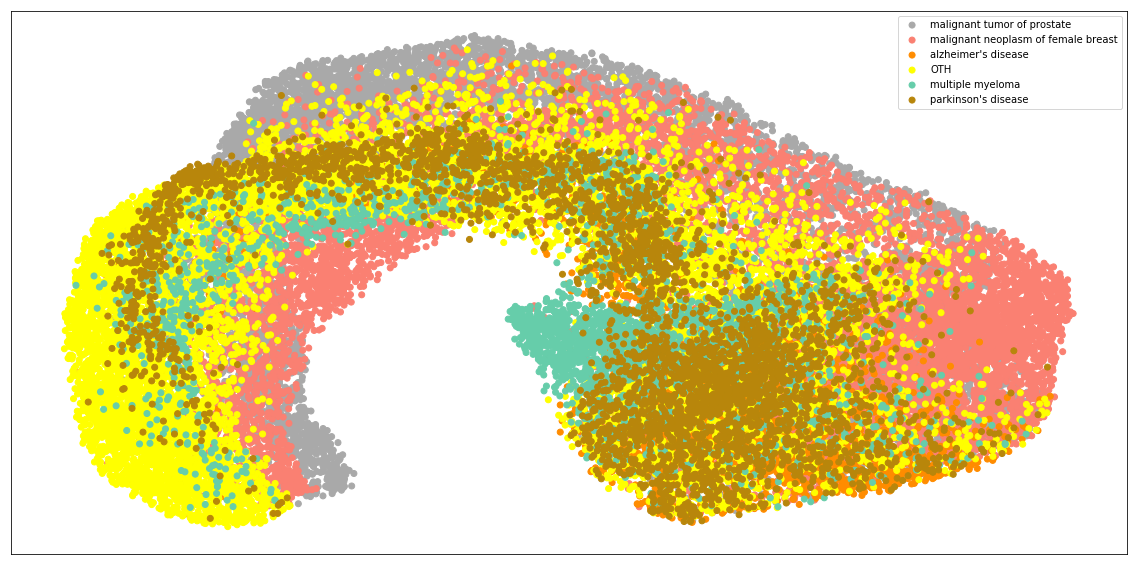

In [68]:
colors_en1 = [colormap[disease_dict[v]] for v in encoded_classes]
single_plot(encoded_umap, encoded_classes, colors_en1)
# single_plot(encoded_umap, encoded_classes, colors_en1)

In [69]:
##Compute classes similarity
disease_sim(encoded_vect, encoded_classes, 'cnn-ae')

Model cnn-ae -- Disease malignant tumor of prostate:: similarity (0.6058529565210475, 0.2002721881997629)
Model cnn-ae -- Disease malignant neoplasm of female breast:: similarity (0.6581050120624363, 0.20831176472286556)
Model cnn-ae -- Disease alzheimer's disease:: similarity (0.7575674296144929, 0.20927523638680767)
Model cnn-ae -- Disease OTH:: similarity (0.6184678733200876, 0.20264282330971606)
Model cnn-ae -- Disease multiple myeloma:: similarity (0.6907938111794627, 0.20376917372993245)
Model cnn-ae -- Disease parkinson's disease:: similarity (0.6329431197324097, 0.2208747977859212)


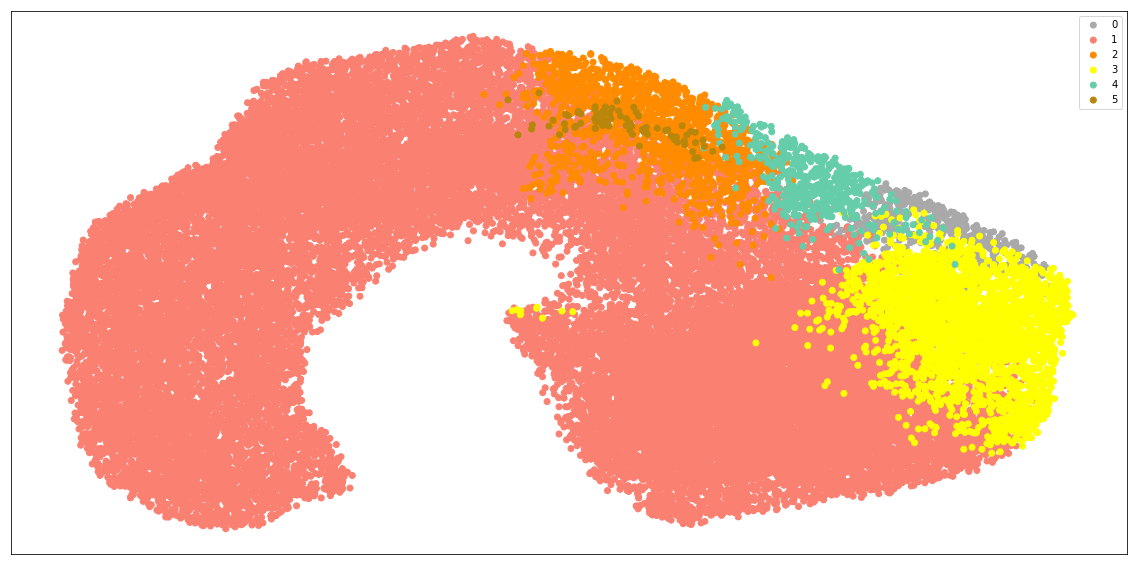

In [70]:
ext_enc_label = hclust.fit_predict(encoded_vect).tolist()
colors_en2 = [colormap[v] for v in ext_enc_label]
single_plot(encoded_umap, ext_enc_label, colors_en2)

In [71]:
##External validation
print("Silhouette score: {0}".format(silhouette_score(encoded_vect, ext_enc_label)))
ext_enc_label = outer_clustering_analysis(encoded_vect, encoded_classes)

Silhouette score: 0.16824188515587907
Cluster: 0 -- Entropy: 1.972, Purity: 0.514
max(P) in cluster disease malignant tumor of prostate
Cluster: 1 -- Entropy: 2.472, Purity: 0.319
max(P) in cluster disease malignant neoplasm of female breast
Cluster: 2 -- Entropy: 2.244, Purity: 0.296
max(P) in cluster disease OTH
Cluster: 3 -- Entropy: 2.191, Purity: 0.316
max(P) in cluster disease malignant tumor of prostate
Cluster: 4 -- Entropy: 2.429, Purity: 0.245
max(P) in cluster disease malignant neoplasm of female breast
Cluster: 5 -- Entropy: 1.717, Purity: 0.597
max(P) in cluster disease OTH
Average Entropy: 2.21
Average Purity: 0.39


### Raw counts

In [ ]:
colors_raw1 = [colormap[disease_dict[v]] for v in raw_classes]
single_plot(raw_tsne, raw_classes, colors_raw1)

In [ ]:
##Compute classes similarity
disease_sim(raw_data_scaled, raw_classes, 'raw counts')

In [ ]:
ext_raw_label = hclust.fit_predict(raw_data_scaled).tolist()
colors_raw2 = [colormap[disease_dict[v]] for v in ext_raw_labels]
single_plot(raw_tsne, ext_raw_label, colors_raw2)

In [ ]:
##External validation
ext_clust(raw_classes, ext_raw_label)

### Tfidf matrix

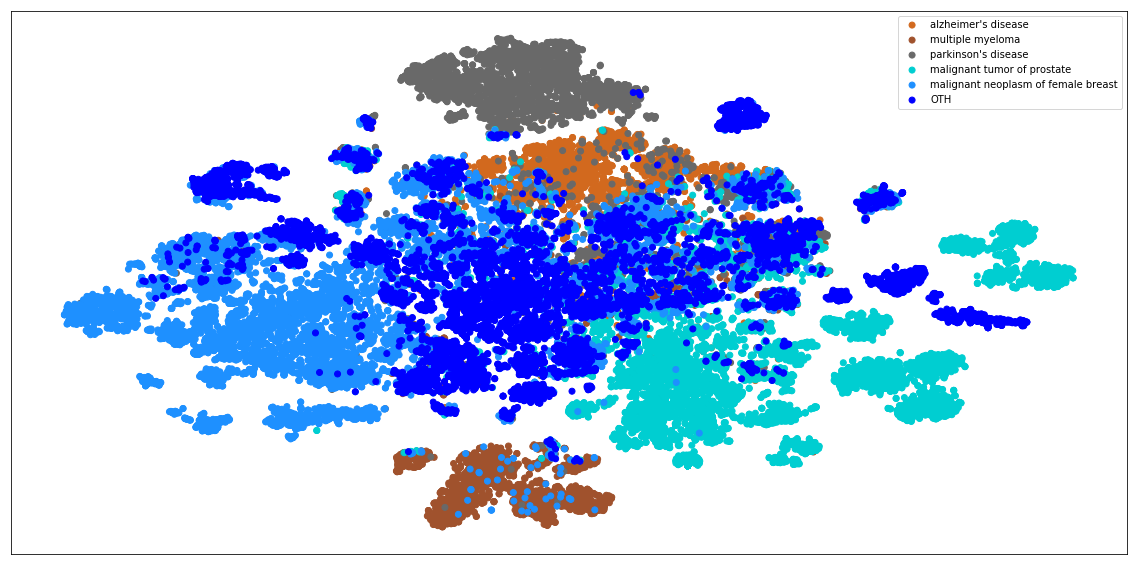

In [21]:
colors_count1 = [colormap[disease_dict[v]] for v in raw_classes]
single_plot(tfidf_tsne, raw_classes, colors_count1)

In [23]:
##Compute classes similarity
disease_sim(svd_mat, raw_classes, 'tfidf')

Model tfidf -- Disease alzheimer's disease:: similarity (0.3369598411904895, 0.16518684120427263)
Model tfidf -- Disease multiple myeloma:: similarity (0.5367440850880364, 0.2624681994002949)
Model tfidf -- Disease parkinson's disease:: similarity (0.42554215391306144, 0.22606793428901317)
Model tfidf -- Disease malignant tumor of prostate:: similarity (0.3536507192646385, 0.21137960060483893)
Model tfidf -- Disease malignant neoplasm of female breast:: similarity (0.2898918618670005, 0.20522161296323652)
Model tfidf -- Disease OTH:: similarity (0.07874645157853694, 0.14564775741483024)


In [27]:
ext_tfidf_label = hclust.fit_predict(svd_mat).tolist()
#colors_count2 = [colormap[v] for v in ext_tfidf_label]
#single_plot(tfidf_tsne, ext_tfidf_label, colors_count2)

In [41]:
print("Silhouette score: {0}".format(silhouette_score(svd_mat, ext_tfidf_label)))
outer_clustering_analysis(svd_mat, raw_classes)

Silhouette score: 0.12420673700766441
[0.06839309428950863, 0.7558654271801682, 0.09694555112881806, 0.038955289951305885, 0.0398406374501992]
Cluster: 0 -- Entropy: 1.264, Purity: 0.756
max(P) in cluster disease attention deficit
[0.6438105943515526, 0.17577631024307994, 0.041450049178024445, 0.1365743993255585, 0.00238864690178446]
Cluster: 1 -- Entropy: 1.453, Purity: 0.644
max(P) in cluster disease OTH
[0.0, 0.9958847736625515, 0.0, 0.0, 0.00411522633744856]
Cluster: 2 -- Entropy: 0.039, Purity: 0.996
max(P) in cluster disease attention deficit
[0.0, 1.0, 0.0, 0.0, 0.0]
Cluster: 3 -- Entropy: 0.000, Purity: 1.000
max(P) in cluster disease attention deficit
[0.0055248618784530384, 0.992633517495396, 0.0, 0.0, 0.001841620626151013]
Cluster: 4 -- Entropy: 0.069, Purity: 0.993
max(P) in cluster disease attention deficit
Average Entropy: 1.23
Average Purity: 0.72


[1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 4,
 4,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 2,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 4,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 4,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 3,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 4,
 0,
 3,
 2,
 2,
 1,
 0,
 0,
 1,
 2,
 2,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 2,
 1,
 1,
 4,
 3,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 3,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 2,
 0,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 4,
 1,
 0,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 0,
 2,
 1,
 1,
 1,
 1,
 0,
 2,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 4,
 0,
 0,
 3,
 0,
 1,
 0,
 0,
 1,
 2,
 1,
 1,
 0,
 0,
 2,
 0,
 0,
 1,
 1,
 1,
 0,
 2,
 1,
 0,
 2,
 1,
 0,
 0,
 0,
 1,
 3,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,


### LSTM model

In [ ]:
colors_lstm1 = [colormap[disease_dict[v]] for v in lstm_classes]
single_plot(lstm_encoded_tsne, lstm_classes, colors_lstmen1)

In [ ]:
disease_sim(lstm_encoded_vect, lstm_classes, 'lstm')

In [ ]:
ext_lstm_label = hclust.fit_predict(lstm_encoded_vect).tolist()
colors_lstm2 = [colormap[v] for v in ext_lstm_label]
single_plot(lstm_encoded_tsne, ext_lstm_label, colors_lstm2)

In [ ]:
ext_clust(lstm_classes, ext_lstm_label)

## Internal validation and disease stratification

### CNN - AE model

In [ ]:
encoded_new_tsne, encoded_new_classes = int_clust(encoded_classes, encoded_vect, mrns, raw_ehr, new_vocab, encoded_tsne)

In [ ]:
encoded_new_disease_dict = {}
for idx, nd in enumerate(set(encoded_new_classes)):
    encoded_new_disease_dict[nd] = idx
colors_en3 = [colormap[encoded_new_disease_dict[v]] for v in encoded_new_classes]
single_plot(encoded_new_tsne, encoded_new_classes, colors_en3)

### Raw counts

In [ ]:
int_clust(raw_classes, raw_data_scaled, raw_mrns, raw_ehr, new_vocab)

### Tfidf matrix

In [ ]:
tfidf_new_tsne, tfidf_new_classes = int_clust(raw_classes, svd_mat, mrn_list, raw_ehr, new_vocab, tfidf_tsne)

In [ ]:
tfidf_new_disease_dict = {}
for idx, nd in enumerate(set(tfidf_new_classes)):
    tfidf_new_disease_dict[nd] = idx
colors_count3 = [colormap[tfidf_new_disease_dict[v]] for v in tfidf_new_classes]
single_plot(tfidf_new_tsne, tfidf_new_classes, colors_count3)

### LSTM model

In [ ]:
int_clust(lstm_classes, lstm_encoded_vect, lstm_mrns, raw_ehr, new_vocab)